# 以下是神经网络方法。

In [1]:
import os
from datetime import datetime

import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD, Adagrad, Adam
from torchvision import datasets, models, transforms
from torchvision.models import (ResNet18_Weights, ResNet50_Weights,
                                VGG11_Weights, resnet18, resnet50, vgg11)
from tqdm import tqdm

from dataset import MyDataset
from my_mlp import MyMLP
from utils import label_int2str, label_str2int, save_config


device = "cuda"
assert torch.cuda.is_available(), "你TM连CUDA都没你跑个JB"

CUDA availability: True


## 运行设置：

In [2]:
# Run name
run_name = datetime.now().strftime("%Y-%m-%d %H.%M.%S")

# Network architecture
# mlp, resnet18, resnet50, vgg11
model_name = "mlp"
model_is_pretrained = False
num_classes = 6

# Optimizer
# SGD, Adagrad, Adam
optimizer_name = "Adam"
lr = 6e-3

# Data augmentation
augmentation = "none"

# Regularization
regularization = "none"

## 模型网络架构：

(Reference from pytorch.org)

| Weight |Acc@1 |Acc@5 |Params |GFLOPS|
| ---- | ---- | ---- | ---- | ---- |
| ResNet18_Weights.IMAGENET1K_V1 | 69.758 | 89.078 | 11.7M | 1.81 |
| ResNet50_Weights.IMAGENET1K_V2 | 80.858 | 95.434 | 25.6M | 4.09 |
| VGG11_Weights.IMAGENET1K_V1 | 69.02 | 88.628 | 132.9M | 7.61 |

In [3]:
if model_name=="mlp":
    model = MyMLP(150*150*3, num_classes)
    input_size = (150, 150)
elif model_name=="resnet18":
    if model_is_pretrained:
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
    else:
        model = resnet18(weights=None)
    input_size = (224, 224)
    model.fc = torch.nn.Linear(512, num_classes)
elif model_name=="resnet50":
    if model_is_pretrained:
        model = resnet50(weights=ResNet50_Weights.DEFAULT)
    else:
        model = resnet50(weights=None)
    input_size = (224, 224)
    model.fc = torch.nn.Linear(512, num_classes)
elif model_name=="vgg11":
    if model_is_pretrained:
        model = vgg11(weights=VGG11_Weights.DEFAULT)
    else:
        model = vgg11(weights=None)
    input_size = (224, 224)
    model.classifier[6] = torch.nn.Linear(4096,num_classes)

model = model.to(device)
print(model)

MyMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=67500, out_features=2048, bias=True)
    (2): ReLU()
    (3): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): ReLU()
    (6): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (7): Linear(in_features=2048, out_features=512, bias=True)
    (8): ReLU()
    (9): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (10): Linear(in_features=512, out_features=128, bias=True)
    (11): ReLU()
    (12): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (13): Linear(in_features=128, out_features=6, bias=True)
  )
)


## 优化器：

In [4]:
if optimizer_name=="SGD":
    optimizer = SGD(model.parameters(), lr=lr)
elif optimizer_name=="Adagrad":
    optimizer = Adagrad(model.parameters(), lr=lr)
elif optimizer_name=="Adam":
    optimizer = Adam(model.parameters(), lr=lr)

## 数据增强与预处理：

In [5]:
if augmentation=="none":
    transform = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.ToTensor()
    ])
elif augmentation=="flip":
    transform = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor()
    ])
elif augmentation=="crop":
    transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size), 
        transforms.ToTensor()
    ])
elif augmentation=="norm":    
    transform = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)), 
        transforms.ToTensor()
    ])
elif augmentation=="all":
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(), 
        transforms.RandomResizedCrop(input_size), 
        transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)), 
        transforms.ToTensor()
    ])

dataset = datasets.ImageFolder("./dataset/seg_train/", transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=8)

## 训练过程：

In [6]:
def train_one_epoch(model: torch.nn.Module, dataloader: DataLoader, transform: transforms.Compose, 
                    optimizer: torch.optim.Optimizer, current_epoch: int):
    correct_predictions = 0
    epoch_instance_count = 0
    epoch_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training epoch %d"%current_epoch):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()*inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        correct_predictions += torch.sum(predictions==labels.data).item()
        epoch_instance_count += inputs.size(0)
    epoch_accuracy = correct_predictions/epoch_instance_count
    epoch_loss /= epoch_instance_count
    if current_epoch%1==0:
        print("Epoch %d (%d instances), loss = %f, accuracy = %f"%(current_epoch, epoch_instance_count, epoch_loss, epoch_accuracy))
    if current_epoch%10==0:
        os.makedirs("./outputs/runs/%s"%run_name, exist_ok=True)
        torch.save(model, "./outputs/runs/%s/model_epoch_%d"%(run_name, current_epoch))
    return epoch_loss, epoch_accuracy

epoch_losses = []
epoch_accuracies = []
model.train()
for epoch in range(1, 101):
    epoch_loss, epoch_accuracy = train_one_epoch(model, dataloader, transform, optimizer, epoch)
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)


Training epoch 1: 100%|██████████| 439/439 [00:19<00:00, 22.52it/s]


Epoch 1 (14034 instances), loss = 1.792309, accuracy = 0.185264


Training epoch 2: 100%|██████████| 439/439 [00:17<00:00, 24.66it/s]


Epoch 2 (14034 instances), loss = 1.520056, accuracy = 0.354710


Training epoch 3: 100%|██████████| 439/439 [00:19<00:00, 22.38it/s]


Epoch 3 (14034 instances), loss = 1.415088, accuracy = 0.428531


Training epoch 4: 100%|██████████| 439/439 [00:18<00:00, 24.24it/s]


Epoch 4 (14034 instances), loss = 1.307200, accuracy = 0.493730


Training epoch 5: 100%|██████████| 439/439 [00:19<00:00, 23.00it/s]


Epoch 5 (14034 instances), loss = 1.241716, accuracy = 0.522374


Training epoch 6: 100%|██████████| 439/439 [00:19<00:00, 22.82it/s]


Epoch 6 (14034 instances), loss = 1.192058, accuracy = 0.545532


Training epoch 7: 100%|██████████| 439/439 [00:19<00:00, 22.94it/s]


Epoch 7 (14034 instances), loss = 1.140423, accuracy = 0.567693


Training epoch 8: 100%|██████████| 439/439 [00:19<00:00, 22.82it/s]


Epoch 8 (14034 instances), loss = 1.100633, accuracy = 0.580376


Training epoch 9: 100%|██████████| 439/439 [00:19<00:00, 22.88it/s]


Epoch 9 (14034 instances), loss = 1.067941, accuracy = 0.596694


Training epoch 10: 100%|██████████| 439/439 [00:19<00:00, 22.85it/s]


Epoch 10 (14034 instances), loss = 1.039242, accuracy = 0.607596


Training epoch 11: 100%|██████████| 439/439 [00:18<00:00, 23.13it/s]


Epoch 11 (14034 instances), loss = 1.009120, accuracy = 0.621491


Training epoch 12: 100%|██████████| 439/439 [00:19<00:00, 23.08it/s]


Epoch 12 (14034 instances), loss = 0.981758, accuracy = 0.634103


Training epoch 13: 100%|██████████| 439/439 [00:19<00:00, 22.46it/s]


Epoch 13 (14034 instances), loss = 0.947514, accuracy = 0.643366


Training epoch 14: 100%|██████████| 439/439 [00:17<00:00, 25.14it/s]


Epoch 14 (14034 instances), loss = 0.917427, accuracy = 0.657831


Training epoch 15: 100%|██████████| 439/439 [00:17<00:00, 25.07it/s]


Epoch 15 (14034 instances), loss = 0.887273, accuracy = 0.668306


Training epoch 16: 100%|██████████| 439/439 [00:17<00:00, 25.08it/s]


Epoch 16 (14034 instances), loss = 0.864747, accuracy = 0.678068


Training epoch 17: 100%|██████████| 439/439 [00:19<00:00, 22.76it/s]


Epoch 17 (14034 instances), loss = 0.845597, accuracy = 0.684766


Training epoch 18: 100%|██████████| 439/439 [00:19<00:00, 22.58it/s]


Epoch 18 (14034 instances), loss = 0.826887, accuracy = 0.693316


Training epoch 19: 100%|██████████| 439/439 [00:19<00:00, 23.03it/s]


Epoch 19 (14034 instances), loss = 0.794458, accuracy = 0.705643


Training epoch 20: 100%|██████████| 439/439 [00:19<00:00, 22.93it/s]


Epoch 20 (14034 instances), loss = 0.763505, accuracy = 0.718541


Training epoch 21: 100%|██████████| 439/439 [00:18<00:00, 24.17it/s]


Epoch 21 (14034 instances), loss = 0.737011, accuracy = 0.727590


Training epoch 22: 100%|██████████| 439/439 [00:18<00:00, 23.79it/s]


Epoch 22 (14034 instances), loss = 0.721160, accuracy = 0.735214


Training epoch 23: 100%|██████████| 439/439 [00:17<00:00, 25.72it/s]


Epoch 23 (14034 instances), loss = 0.695909, accuracy = 0.749252


Training epoch 24: 100%|██████████| 439/439 [00:17<00:00, 25.69it/s]


Epoch 24 (14034 instances), loss = 0.676348, accuracy = 0.751318


Training epoch 25: 100%|██████████| 439/439 [00:17<00:00, 25.13it/s]


Epoch 25 (14034 instances), loss = 0.639994, accuracy = 0.763289


Training epoch 26: 100%|██████████| 439/439 [00:17<00:00, 24.84it/s]


Epoch 26 (14034 instances), loss = 0.626947, accuracy = 0.768491


Training epoch 27: 100%|██████████| 439/439 [00:17<00:00, 24.78it/s]


Epoch 27 (14034 instances), loss = 0.608558, accuracy = 0.775901


Training epoch 28: 100%|██████████| 439/439 [00:17<00:00, 24.64it/s]


Epoch 28 (14034 instances), loss = 0.582069, accuracy = 0.785877


Training epoch 29: 100%|██████████| 439/439 [00:17<00:00, 24.87it/s]


Epoch 29 (14034 instances), loss = 0.551903, accuracy = 0.798418


Training epoch 30: 100%|██████████| 439/439 [00:17<00:00, 24.85it/s]


Epoch 30 (14034 instances), loss = 0.542554, accuracy = 0.802693


Training epoch 31: 100%|██████████| 439/439 [00:17<00:00, 24.91it/s]


Epoch 31 (14034 instances), loss = 0.511052, accuracy = 0.814736


Training epoch 32: 100%|██████████| 439/439 [00:17<00:00, 25.12it/s]


Epoch 32 (14034 instances), loss = 0.489206, accuracy = 0.824141


Training epoch 33: 100%|██████████| 439/439 [00:17<00:00, 25.14it/s]


Epoch 33 (14034 instances), loss = 0.473643, accuracy = 0.827562


Training epoch 34: 100%|██████████| 439/439 [00:17<00:00, 24.95it/s]


Epoch 34 (14034 instances), loss = 0.454118, accuracy = 0.835614


Training epoch 35: 100%|██████████| 439/439 [00:17<00:00, 24.98it/s]


Epoch 35 (14034 instances), loss = 0.424839, accuracy = 0.844592


Training epoch 36: 100%|██████████| 439/439 [00:17<00:00, 24.88it/s]


Epoch 36 (14034 instances), loss = 0.431438, accuracy = 0.842525


Training epoch 37: 100%|██████████| 439/439 [00:17<00:00, 24.79it/s]


Epoch 37 (14034 instances), loss = 0.405216, accuracy = 0.850862


Training epoch 38: 100%|██████████| 439/439 [00:17<00:00, 25.13it/s]


Epoch 38 (14034 instances), loss = 0.408302, accuracy = 0.850862


Training epoch 39: 100%|██████████| 439/439 [00:17<00:00, 24.86it/s]


Epoch 39 (14034 instances), loss = 0.361876, accuracy = 0.868819


Training epoch 40: 100%|██████████| 439/439 [00:17<00:00, 25.09it/s]


Epoch 40 (14034 instances), loss = 0.378508, accuracy = 0.861693


Training epoch 41: 100%|██████████| 439/439 [00:17<00:00, 24.83it/s]


Epoch 41 (14034 instances), loss = 0.345603, accuracy = 0.876229


Training epoch 42: 100%|██████████| 439/439 [00:17<00:00, 24.94it/s]


Epoch 42 (14034 instances), loss = 0.326592, accuracy = 0.880647


Training epoch 43: 100%|██████████| 439/439 [00:17<00:00, 24.85it/s]


Epoch 43 (14034 instances), loss = 0.325174, accuracy = 0.879721


Training epoch 44: 100%|██████████| 439/439 [00:17<00:00, 25.13it/s]


Epoch 44 (14034 instances), loss = 0.314667, accuracy = 0.886205


Training epoch 45: 100%|██████████| 439/439 [00:17<00:00, 24.97it/s]


Epoch 45 (14034 instances), loss = 0.304507, accuracy = 0.889981


Training epoch 46: 100%|██████████| 439/439 [00:17<00:00, 25.08it/s]


Epoch 46 (14034 instances), loss = 0.281217, accuracy = 0.895539


Training epoch 47: 100%|██████████| 439/439 [00:17<00:00, 24.75it/s]


Epoch 47 (14034 instances), loss = 0.272620, accuracy = 0.899815


Training epoch 48: 100%|██████████| 439/439 [00:17<00:00, 24.82it/s]


Epoch 48 (14034 instances), loss = 0.283773, accuracy = 0.898176


Training epoch 49: 100%|██████████| 439/439 [00:17<00:00, 24.51it/s]


Epoch 49 (14034 instances), loss = 0.270193, accuracy = 0.901739


Training epoch 50: 100%|██████████| 439/439 [00:17<00:00, 24.64it/s]


Epoch 50 (14034 instances), loss = 0.255537, accuracy = 0.906727


Training epoch 51: 100%|██████████| 439/439 [00:17<00:00, 24.68it/s]


Epoch 51 (14034 instances), loss = 0.240153, accuracy = 0.914208


Training epoch 52: 100%|██████████| 439/439 [00:17<00:00, 24.43it/s]


Epoch 52 (14034 instances), loss = 0.248169, accuracy = 0.910004


Training epoch 53: 100%|██████████| 439/439 [00:17<00:00, 24.61it/s]


Epoch 53 (14034 instances), loss = 0.222039, accuracy = 0.918127


Training epoch 54: 100%|██████████| 439/439 [00:17<00:00, 24.96it/s]


Epoch 54 (14034 instances), loss = 0.224450, accuracy = 0.918056


Training epoch 55: 100%|██████████| 439/439 [00:17<00:00, 24.96it/s]


Epoch 55 (14034 instances), loss = 0.214372, accuracy = 0.922260


Training epoch 56: 100%|██████████| 439/439 [00:17<00:00, 24.64it/s]


Epoch 56 (14034 instances), loss = 0.205595, accuracy = 0.924398


Training epoch 57: 100%|██████████| 439/439 [00:17<00:00, 24.78it/s]


Epoch 57 (14034 instances), loss = 0.208276, accuracy = 0.922260


Training epoch 58: 100%|██████████| 439/439 [00:17<00:00, 25.24it/s]


Epoch 58 (14034 instances), loss = 0.211063, accuracy = 0.924754


Training epoch 59: 100%|██████████| 439/439 [00:17<00:00, 25.02it/s]


Epoch 59 (14034 instances), loss = 0.169627, accuracy = 0.940217


Training epoch 60: 100%|██████████| 439/439 [00:17<00:00, 24.81it/s]


Epoch 60 (14034 instances), loss = 0.181996, accuracy = 0.935941


Training epoch 61: 100%|██████████| 439/439 [00:17<00:00, 24.68it/s]


Epoch 61 (14034 instances), loss = 0.177963, accuracy = 0.936725


Training epoch 62: 100%|██████████| 439/439 [00:18<00:00, 23.51it/s]


Epoch 62 (14034 instances), loss = 0.179334, accuracy = 0.937580


Training epoch 63: 100%|██████████| 439/439 [00:20<00:00, 21.92it/s]


Epoch 63 (14034 instances), loss = 0.155424, accuracy = 0.941000


Training epoch 64: 100%|██████████| 439/439 [00:19<00:00, 22.21it/s]


Epoch 64 (14034 instances), loss = 0.151931, accuracy = 0.944991


Training epoch 65: 100%|██████████| 439/439 [00:19<00:00, 22.26it/s]


Epoch 65 (14034 instances), loss = 0.155695, accuracy = 0.944278


Training epoch 66: 100%|██████████| 439/439 [00:18<00:00, 23.30it/s]


Epoch 66 (14034 instances), loss = 0.128620, accuracy = 0.954967


Training epoch 67: 100%|██████████| 439/439 [00:19<00:00, 22.13it/s]


Epoch 67 (14034 instances), loss = 0.158577, accuracy = 0.944207


Training epoch 68: 100%|██████████| 439/439 [00:19<00:00, 22.02it/s]


Epoch 68 (14034 instances), loss = 0.155690, accuracy = 0.944207


Training epoch 69: 100%|██████████| 439/439 [00:19<00:00, 21.95it/s]


Epoch 69 (14034 instances), loss = 0.149189, accuracy = 0.945276


Training epoch 70: 100%|██████████| 439/439 [00:19<00:00, 22.08it/s]


Epoch 70 (14034 instances), loss = 0.150936, accuracy = 0.946558


Training epoch 71: 100%|██████████| 439/439 [00:19<00:00, 22.03it/s]


Epoch 71 (14034 instances), loss = 0.128642, accuracy = 0.954824


Training epoch 72: 100%|██████████| 439/439 [00:19<00:00, 21.97it/s]


Epoch 72 (14034 instances), loss = 0.123075, accuracy = 0.956605


Training epoch 73: 100%|██████████| 439/439 [00:19<00:00, 22.27it/s]


Epoch 73 (14034 instances), loss = 0.141208, accuracy = 0.950264


Training epoch 74: 100%|██████████| 439/439 [00:19<00:00, 22.24it/s]


Epoch 74 (14034 instances), loss = 0.131978, accuracy = 0.950264


Training epoch 75: 100%|██████████| 439/439 [00:18<00:00, 23.23it/s]


Epoch 75 (14034 instances), loss = 0.110146, accuracy = 0.959883


Training epoch 76: 100%|██████████| 439/439 [00:19<00:00, 22.70it/s]


Epoch 76 (14034 instances), loss = 0.116429, accuracy = 0.958743


Training epoch 77: 100%|██████████| 439/439 [00:19<00:00, 22.70it/s]


Epoch 77 (14034 instances), loss = 0.105061, accuracy = 0.962876


Training epoch 78: 100%|██████████| 439/439 [00:18<00:00, 23.85it/s]


Epoch 78 (14034 instances), loss = 0.120269, accuracy = 0.955537


Training epoch 79: 100%|██████████| 439/439 [00:19<00:00, 22.59it/s]


Epoch 79 (14034 instances), loss = 0.115969, accuracy = 0.958672


Training epoch 80: 100%|██████████| 439/439 [00:19<00:00, 22.76it/s]


Epoch 80 (14034 instances), loss = 0.098329, accuracy = 0.966581


Training epoch 81: 100%|██████████| 439/439 [00:17<00:00, 24.60it/s]


Epoch 81 (14034 instances), loss = 0.103815, accuracy = 0.963303


Training epoch 82: 100%|██████████| 439/439 [00:19<00:00, 22.89it/s]


Epoch 82 (14034 instances), loss = 0.097215, accuracy = 0.965370


Training epoch 83: 100%|██████████| 439/439 [00:19<00:00, 22.88it/s]


Epoch 83 (14034 instances), loss = 0.107275, accuracy = 0.963161


Training epoch 84: 100%|██████████| 439/439 [00:19<00:00, 22.91it/s]


Epoch 84 (14034 instances), loss = 0.100638, accuracy = 0.964729


Training epoch 85: 100%|██████████| 439/439 [00:19<00:00, 22.92it/s]


Epoch 85 (14034 instances), loss = 0.093818, accuracy = 0.967579


Training epoch 86: 100%|██████████| 439/439 [00:19<00:00, 22.72it/s]


Epoch 86 (14034 instances), loss = 0.101378, accuracy = 0.965085


Training epoch 87: 100%|██████████| 439/439 [00:18<00:00, 23.19it/s]


Epoch 87 (14034 instances), loss = 0.116955, accuracy = 0.962163


Training epoch 88: 100%|██████████| 439/439 [00:19<00:00, 21.96it/s]


Epoch 88 (14034 instances), loss = 0.093628, accuracy = 0.967579


Training epoch 89: 100%|██████████| 439/439 [00:17<00:00, 24.67it/s]


Epoch 89 (14034 instances), loss = 0.076996, accuracy = 0.971427


Training epoch 90: 100%|██████████| 439/439 [00:19<00:00, 22.55it/s]


Epoch 90 (14034 instances), loss = 0.106790, accuracy = 0.963090


Training epoch 91: 100%|██████████| 439/439 [00:17<00:00, 24.84it/s]


Epoch 91 (14034 instances), loss = 0.075171, accuracy = 0.972567


Training epoch 92: 100%|██████████| 439/439 [00:17<00:00, 24.39it/s]


Epoch 92 (14034 instances), loss = 0.066844, accuracy = 0.976628


Training epoch 93: 100%|██████████| 439/439 [00:17<00:00, 25.20it/s]


Epoch 93 (14034 instances), loss = 0.102194, accuracy = 0.965085


Training epoch 94: 100%|██████████| 439/439 [00:18<00:00, 24.34it/s]


Epoch 94 (14034 instances), loss = 0.070807, accuracy = 0.974562


Training epoch 95: 100%|██████████| 439/439 [00:17<00:00, 24.77it/s]


Epoch 95 (14034 instances), loss = 0.079061, accuracy = 0.972424


Training epoch 96: 100%|██████████| 439/439 [00:17<00:00, 24.63it/s]


Epoch 96 (14034 instances), loss = 0.081365, accuracy = 0.973208


Training epoch 97: 100%|██████████| 439/439 [00:17<00:00, 24.72it/s]


Epoch 97 (14034 instances), loss = 0.101718, accuracy = 0.966082


Training epoch 98: 100%|██████████| 439/439 [00:17<00:00, 24.51it/s]


Epoch 98 (14034 instances), loss = 0.076869, accuracy = 0.972068


Training epoch 99: 100%|██████████| 439/439 [00:17<00:00, 25.07it/s]


Epoch 99 (14034 instances), loss = 0.066044, accuracy = 0.977412


Training epoch 100: 100%|██████████| 439/439 [00:17<00:00, 25.29it/s]


Epoch 100 (14034 instances), loss = 0.066565, accuracy = 0.978196


## 测试网络：

In [7]:
def test(model: torch.nn.Module, dataloader: DataLoader):
    correct_predictions = 0
    epoch_instance_count = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            correct_predictions += torch.sum(predictions==labels.data)
            epoch_instance_count += inputs.size(0)
    epoch_accuracy = correct_predictions/epoch_instance_count
    print("Testing (%d instances), accuracy = %f"%(epoch_instance_count, epoch_accuracy))

testset = datasets.ImageFolder("./dataset/seg_test/", transform = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.ToTensor()
    ])) # Do not transform input images in testing. 
testloader = DataLoader(testset, batch_size=32, shuffle=True, num_workers=0)
test(model, testloader)
save_config(run_name, model_name, model_is_pretrained, num_classes, optimizer_name, lr, augmentation, regularization)

Testing: 100%|██████████| 94/94 [00:02<00:00, 45.63it/s]

Testing (3000 instances), accuracy = 0.547333
# Run name
run_name = "2023-05-14 22.58.27"

# Network architecture
# mlp, resnet18, resnet50, vgg11
model_name = "mlp"
model_is_pretrained = False
num_classes = 6

# Optimizer
# SGD, Adagrad, Adam
optimizer_name = "Adam"
lr = 0.006000

# Data augmentation
augmentation = "none"

# Regularization
regularization = "none"
    


## 画图

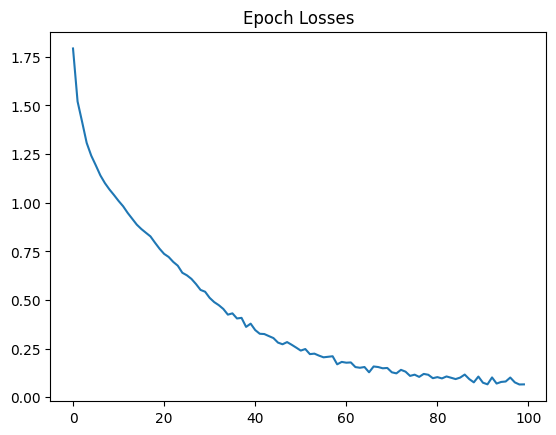

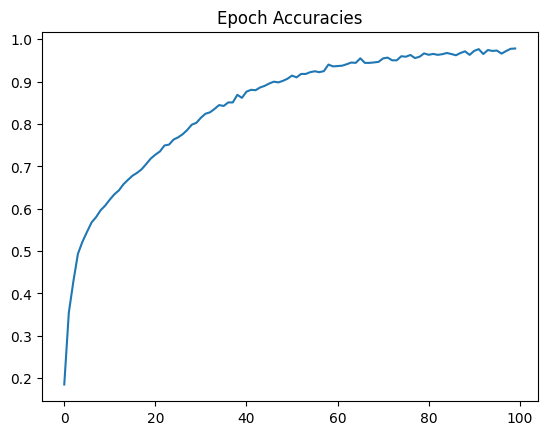

In [9]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.title("Epoch Losses")
plt.savefig("./outputs/runs/%s/loss.png"%run_name)
plt.show()
plt.plot(epoch_accuracies)
plt.title("Epoch Accuracies")
plt.savefig("./outputs/runs/%s/acc.png"%run_name)
plt.show()